 ╔══<i><b>Alai-DeepLearning</b></i>════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 5. Machine Learning Basis**
# Section 4. Tensorflow을 이용한 Linear Regression 구현

### _Objective_
1. Tensorflow을 통해 우리는 선형회귀를 구현합니다. <br>
  
╚═════════════════════════════════════════╝

In [3]:
%matplotlib inline
!pip install tensorboardcolab

import tensorboardcolab
import numpy as np
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Using TensorFlow backend.


### [Optional.  Tensorflow Graph Visualization ]

---

> _Jupyter에서 Tensorflow에서 구성되는 Graph를 시각적으로 보여주기 위한 helper 메소드입니다._<br>


In [4]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

## 예제 데이터 ) 빅데이터로 예측한 '옥자' 관객 수

"이전까지 개봉했던 영화의 보고싶어요 수와 관객 수를 바탕으로, 옥자의 예상 관객 수 예측하기"

reference : [빅데이터로 예측한 옥자 관객 수 727만 명](http://platum.kr/wp-content/uploads/2017/06/unnamed-12.png)
![](http://platum.kr/wp-content/uploads/2017/06/unnamed-12.png)

In [5]:
movie_df = pd.DataFrame([
    [8759, 487],
    [10132,612],
    [12078,866],
    [16430,1030]],
    columns=["nums_want_to_see","nums_audience"])
movie_df.index = ["마션","킹스맨","캡틴아메리카","인터스텔라"]
movie_df

,nums_want_to_see,nums_audience
마션,8759,487
킹스맨,10132,612
캡틴아메리카,12078,866
인터스텔라,16430,1030


<br><br>

# \[ 1. 학습이 잘 되지 않는 이유 \]

----

----

> *선형 회귀 모델을 그래프로 구현해보도록 하겠습니다.*<br>

## 1. 이전 코드 재학습 시키기
---


In [20]:
# 손실 함수값 계산하기
def calculate_MSE(W0, W1):
    X = movie_df.nums_want_to_see # 독립 변수, 보고싶어요 수
    y_true = movie_df.nums_audience # 실제값

    y_pred = W1*X+W0 # 가중치 조합을 통한 예측값
    return ((y_true - y_pred)**2).mean() # MSE

# W0에 대한 미분식
def calculate_wo_derivative(w0,w1):
    x = movie_df.nums_want_to_see # 독립 변수, 보고싶어요 수
    y_true = movie_df.nums_audience # 실제값
    return (w1*x + w0 - y_true).mean()

# W1에 대한 미분식
def calculate_w1_derivative(w0,w1):
    x = movie_df.nums_want_to_see # 독립 변수, 보고싶어요 수
    y_true = movie_df.nums_audience # 실제값
    return ((w1*x + w0 - y_true)*x).mean()

In [21]:
w0 = -500
w1 = -0.75
mse = calculate_MSE(w0,w1)

In [47]:
# 갱신된 weight와 mse 저장
w0_history = [w0]
w1_history = [w1]
mse_history = [mse]
dw0_history = []
dw1_history = []

alpha = 2e-10 # 학습률
epoch = 100 # 몇 번 학습할지 결정

for i in range(epoch):
    # 이전 가중치 가져오기
    old_w0 = w0_history[-1]
    old_w1 = w1_history[-1]
    
    # 미분값 갱신
    dw0 = calculate_wo_derivative(old_w0,old_w1)
    dw1 = calculate_w1_derivative(old_w0,old_w1)
    
    # 경사하강법을 통한 가중치 갱신
    new_w0 = old_w0 - alpha * dw0
    new_w1 = old_w1 - alpha * dw1
    new_mse = calculate_MSE(new_w0,new_w1)
    
    # 결과 저장
    w0_history.append(new_w0)
    w1_history.append(new_w1)
    dw0_history.append(dw0)
    dw1_history.append(dw1)    
    mse_history.append(new_mse)

## 2. 결과 확인하기
---

In [48]:
hist_df = pd.DataFrame({
    "W0":w0_history[:-1],
    "W1":w1_history[:-1],
    "dw0":dw0_history,
    "dw1":dw1_history,    
    "Loss":mse_history[:-1]
})

### (1) 손실함수 값 확인하기

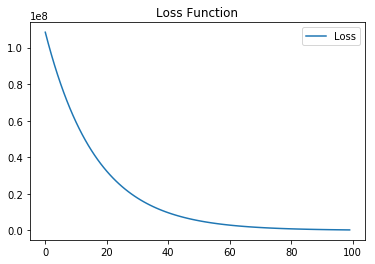

In [49]:
hist_df.plot(y='Loss')
plt.title("Loss Function")
plt.show()

### (2) Weight 값 추이 확인하기

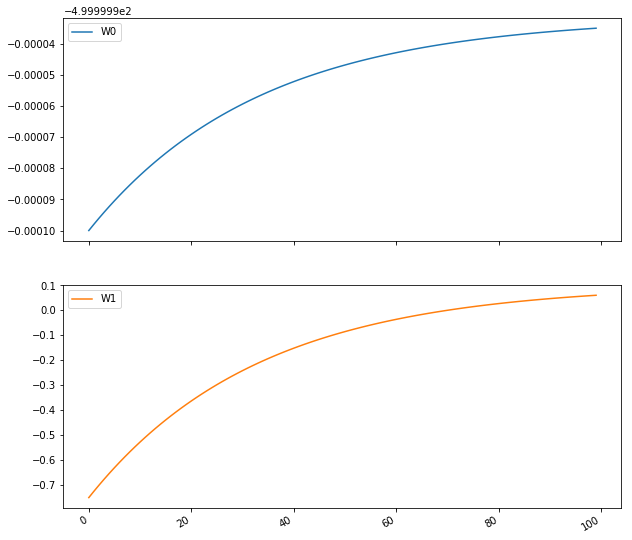

In [60]:
# W1은 어느정도 바뀌었지만, W0은 전혀 변하지 않았다.
hist_df.plot(y=['W0','W1'],subplots=True,figsize=(10,10))
plt.show()

### (3) 기울기 값 추이 확인하기

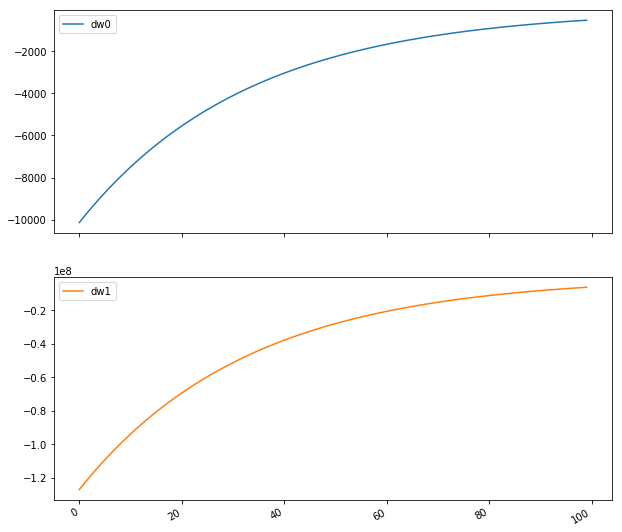

In [59]:
# Delta 값의 변화가 너무 큽니다.
# dw0은 10^4의 크기를 보이고 있는데, dw1은 10^8의 크기를 보이고 있습니다.
hist_df.plot(y=['dw0','dw1'],subplots=True,figsize=(10,10))
plt.show()

위의 문제를 방지해주기 위해, 우리는 기본적으로 **Feature Scaling**을 적용합니다.

## 3. Feature Scale 적용 후, 학습 시키기
---
* Featrue Scale에 관한 구체적인 설명은 다음 시간에 하겠습니다.
* 간단하게 여기서는 Min-Max Normalization을 적용하겠습니다.

In [69]:
# Min-Max Normalization 적용
movie_df = (movie_df - movie_df.min())/(movie_df.max()-movie_df.min())
movie_df.describe()

,nums_want_to_see,nums_audience
count,4.000000,4.000000
mean,0.402914,0.482044
std,0.435844,0.451182
min,0.000000,0.000000
25%,0.134239,0.172652
50%,0.305827,0.464088
75%,0.574501,0.773481
max,1.000000,1.000000


In [70]:
w0 = -0.1
w1 = -0.1
mse = calculate_MSE(w0,w1)

* 학습률을 보다 올려서 동작시키겠습니다.

In [93]:
# 갱신된 weight와 mse 저장
w0_history = [w0]
w1_history = [w1]
mse_history = [mse]
dw0_history = []
dw1_history = []

alpha = 2e-1 # 학습률
epoch = 100 # 몇 번 학습할지 결정

for i in range(epoch):
    # 이전 가중치 가져오기
    old_w0 = w0_history[-1]
    old_w1 = w1_history[-1]
    
    # 미분값 갱신
    dw0 = calculate_wo_derivative(old_w0,old_w1)
    dw1 = calculate_w1_derivative(old_w0,old_w1)
    
    # 경사하강법을 통한 가중치 갱신
    new_w0 = old_w0 - alpha * dw0
    new_w1 = old_w1 - alpha * dw1
    new_mse = calculate_MSE(new_w0,new_w1)
    
    # 결과 저장
    w0_history.append(new_w0)
    w1_history.append(new_w1)
    dw0_history.append(dw0)
    dw1_history.append(dw1)    
    mse_history.append(new_mse)

## 4. Feature Scale 적용 후, 결과 확인하기
---
* Feature Scaling을 적용한 후, 결과의 변화는 극적으로 안정적으로 됩니다.

In [94]:
hist_df = pd.DataFrame({
    "W0":w0_history[:-1],
    "W1":w1_history[:-1],
    "dw0":dw0_history,
    "dw1":dw1_history,    
    "Loss":mse_history[:-1]
})

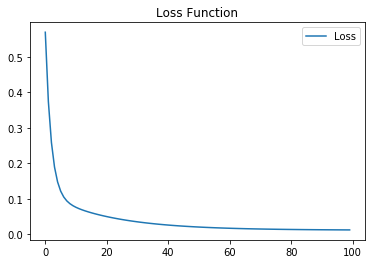

In [95]:
hist_df.plot(y='Loss')
plt.title("Loss Function")
plt.show()

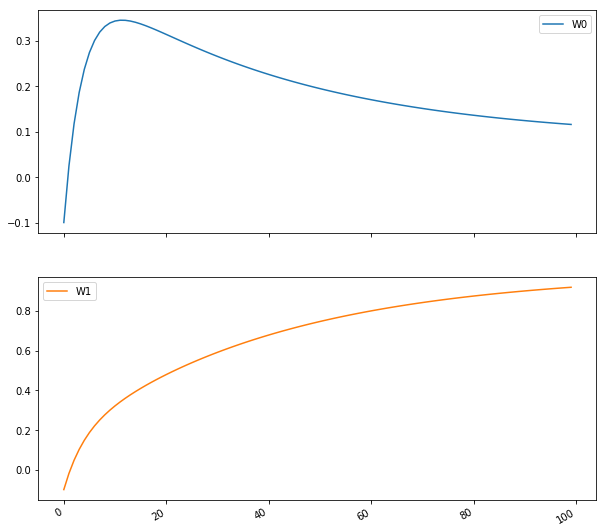

In [96]:
# W0, W1모두 비슷한 수준으로 변화하였습니다.
hist_df.plot(y=['W0','W1'],subplots=True,figsize=(10,10))
plt.show()

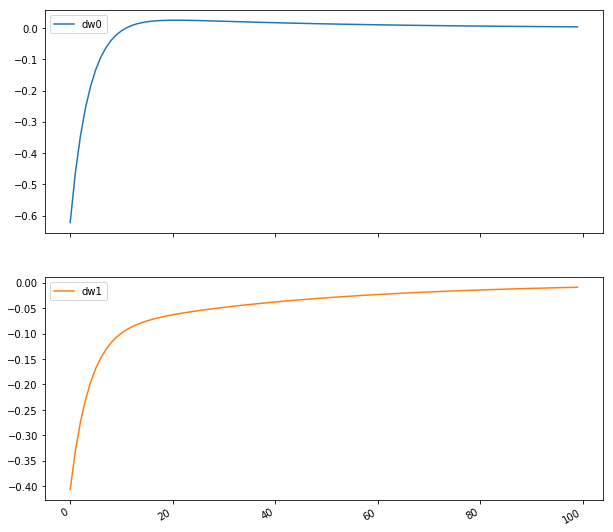

In [97]:
# Delta 값 또한 비슷한 수준의 차이를 보이고 있습니다.
hist_df.plot(y=['dw0','dw1'],subplots=True,figsize=(10,10))
plt.show()

* 위와 같이 안정적으로 학습을 시키기 위해서는 Feature Scaling이 필수적입니다.

<br><br>

# \[ 2. TensorFlow Graph 그리기 \]

----

----

> *선형 회귀 모델을 그래프로 구현해보도록 하겠습니다.*<br>

<br>

## 1.  placeholder 생성

----

* 선형 회귀 모델을 학습시키고, 예측하기 위해서는<br>
  독립 변수(X), 종속 변수(Y), 학습률(learning rate)을 받아오는 placeholder가 필요합니다.

In [98]:
tf.reset_default_graph()

# Data를 받아오는 placeholder
x = tf.placeholder(tf.float32, shape=(None,), name='x')
y_true = tf.placeholder(tf.float32, shape=(None,), name="y_true")
learning_rate = tf.placeholder(tf.float32, name="learning_rate")

## 2.  weight 생성

----


* 우리는 학습해야 하는 두개의 가중치 ($W_0$,$W_1$)가 있습니다.<br>
  이전과 동일하게 초깃값을 (-0.1,-0.1)로 두겠습니다.

In [112]:
# Weight 초기화
with tf.variable_scope('weights'):
    w0 = tf.Variable(-0.1,name='W0')
    w1 = tf.Variable(-0.1,name='W1')

## 3. 예측 모델 $\hat y$ 구현

---

* 선형회귀 예측 모델인 아래의 수식을 구현해야 합니다.
$$
\hat y = w_1 * x + w_0
$$

In [100]:
# Y_hat 구하기
with tf.variable_scope('linear_regression'):
    y_pred = w1*x + w0

In [101]:
show_graph(tf.get_default_graph())

선형회귀로 예측하기 위해서는 weight와 x만 있으면 됩니다.

## 4. 손실함수 구현

---


$$
\mbox{손실함수 : } Loss(W_0,W_1) = \frac{1}{2m}\sum_{i=1}^{m}(\hat y - y)^2 = \frac{1}{2m}\sum_{i=1}^{m}(w_1x^{(i)}+w_0-y^{(i)})^2
$$

In [102]:
# MSE_loss
with tf.variable_scope('loss'):
    mse_loss = tf.reduce_mean(tf.square(y_pred-y_true))
    tf.add_to_collection(tf.GraphKeys.LOSSES,mse_loss)

In [103]:
show_graph(tf.get_default_graph())

## 5. Gradient Descent 알고리즘 구현하기

---


각 Weight들의 기울기는 아래와 같습니다.

$$
\frac{\partial Loss}{\partial W_0} = \frac{1}{m}\sum_{i=1}^{m}(w_1x^{(i)}+w_0 - y^{(i)})\\
\frac{\partial Loss}{\partial W_1} = \frac{1}{m}\sum_{i=1}^{m}(w_1x^{(i)}+w_0 - y^{(i)})x^{(i)}\\
$$

Gradient Descent 알고리즘의 수식은 아래와 같습니다.
$$
W_{new} = W_{old} - \alpha * \frac{\partial loss}{\partial W} 
$$


In [104]:
# weight 별 gradient 구하기
with tf.variable_scope('gradient_descent'):
    grad_w0 = tf.reduce_mean(w1*x + w0 - y_true, 
                             name="gradient_w0")
    grad_w1 = tf.reduce_mean((w1*x + w0 - y_true)*x,
                             name='gradient_w1')

    update_w0 = tf.assign_sub(w0, learning_rate*grad_w0,
                              name="update_w0")
    update_w1 = tf.assign_sub(w1, learning_rate*grad_w1,
                              name='update_w1')

    train_op = tf.group([update_w0,update_w1],
                        name='train_op')
    tf.add_to_collection(tf.GraphKeys.TRAIN_OP,train_op)

In [105]:
show_graph(tf.get_default_graph())

<br><br>

# \[ 3. TensorFlow로 학습시키기 \]

----

----

> *Tensorflow로 만든 graph을 Session으로 학습시켜보겠습니다. *<br>

<br>

## 1. Tensor와 Operation 가져오기 

---

* training에서 필요한 Tensor와 Operation들을 가져옵니다.

In [106]:
graph = tf.get_default_graph()

x = graph.get_tensor_by_name('x:0')
y = graph.get_tensor_by_name('y_true:0')
learning_rate = graph.get_tensor_by_name('learning_rate:0')

w1 = graph.get_tensor_by_name('weights/W1:0')
w0 = graph.get_tensor_by_name('weights/W0:0')

mse_loss = graph.get_collection(tf.GraphKeys.LOSSES)[0]
train_op = graph.get_collection(tf.GraphKeys.TRAIN_OP)[0]

In [107]:
show_graph(graph)

<br>
## 2. Tensorboard에서 Tracking할 summary 추가

---


In [108]:
tf.summary.scalar('Mean_Squared_Error',mse_loss)
tf.summary.scalar('weight_1',w1)
tf.summary.scalar('weight_0',w0)

merged_summary = tf.summary.merge_all()

<br>
## 3. Session을 만들어 학습시키기

---


In [109]:
sess = tf.Session(graph=graph)

# 변수 초기화하기
sess.run(tf.global_variables_initializer())

# tensorboard에 기록할 writer 객체 만들기
writer = tf.summary.FileWriter(logdir='./linear_regression',
                               graph=graph)

for epoch in range(100):
    # nums_epoch : 100    
    _,merged_ = sess.run([train_op,merged_summary],
             feed_dict={
                 x:movie_df.nums_want_to_see.values,
                 y:movie_df.nums_audience.values,
                 learning_rate:2e-1
             })
    
    # summary 기록하기
    writer.add_summary(merged_, epoch)
writer.flush()

In [110]:
# Weight1 과 Weight2 확인하기
sess.run([w1,w0])

[-0.74999404, -500.0]

<br>
## 4. tensorboard로 결과 확인하기
---


In [111]:
# 텐서보드 가져오기
tbc = tensorboardcolab.TensorBoardColab(graph_path='./linear_regression')

Wait for 8 seconds...
Initialization failed, retry again (1)


Wait for 8 seconds...
Initialization failed, retry again (2)


Wait for 8 seconds...
Initialization failed, retry again (3)


Wait for 8 seconds...
Initialization failed, retry again (4)


Wait for 8 seconds...
Initialization failed, retry again (5)


Wait for 8 seconds...
Initialization failed, retry again (6)


Wait for 8 seconds...
Initialization failed, retry again (7)


Wait for 8 seconds...
Initialization failed, retry again (8)


Wait for 8 seconds...
Initialization failed, retry again (9)


Wait for 8 seconds...
Initialization failed, retry again (10)


Wait for 8 seconds...
Initialization failed, retry again (11)


Wait for 8 seconds...
Initialization failed, retry again (12)


Wait for 8 seconds...
Initialization failed, retry again (13)


Wait for 8 seconds...
Initialization failed, retry again (14)


Wait for 8 seconds...
Initialization failed, retry again (15)


Wait for 8 seconds...
Initialization failed, retr

KeyboardInterrupt: 

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/03/22

---